Found Object IDs: ['1000', '10000', '100003', '100012', '100018']
Using Original_Object_ID: 1000
Columns found: ['_id', 'Original_Object_ID', 'MJD', 'Magnitude', 'Magnitude_Error']


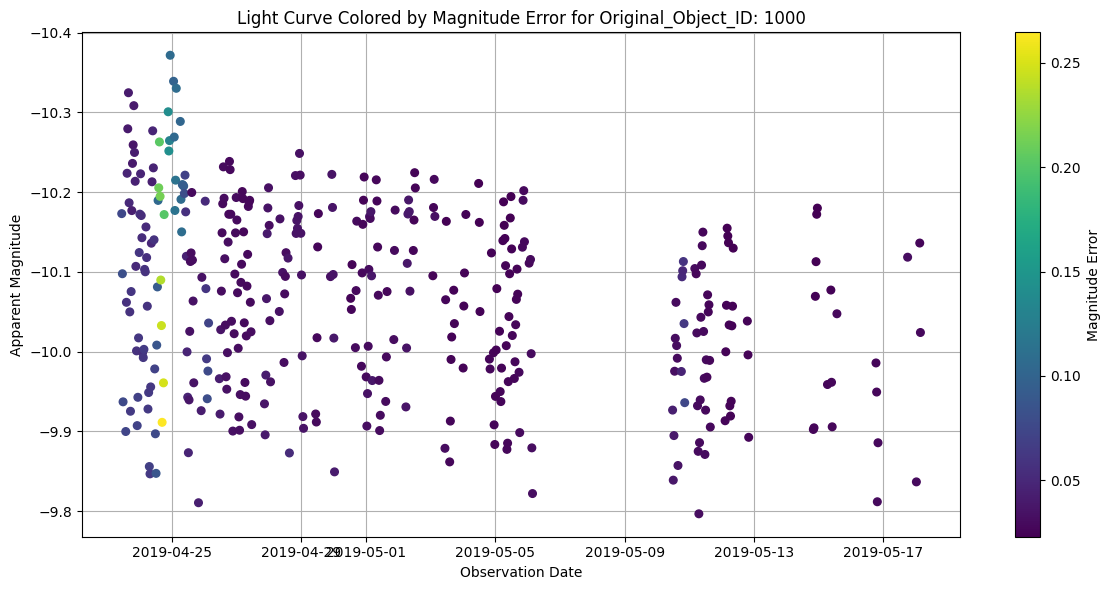

In [1]:
from pymongo import MongoClient
import configparser as cfp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

# MongoDB connection class
class Mongo:
    def __init__(self):
        config = cfp.ConfigParser()
        config.read('config.ini')
        user = config.get('Database', 'dbUser')
        host = config.get('Database', 'dbHost')
        port = config.get('Database', 'dbPort')
        pswd = config.get('Database', 'dbPass')

        if user and pswd:
            dest = f"mongodb://{user}:{pswd}@{host}:{port}"
        else:
            dest = f"mongodb://{host}:{port}"

        client = MongoClient(dest)
        self.db = client.tess

    def getData(self, dbKey):
        return self.db[dbKey]


# Step 1: Connect to MongoDB
mongo = Mongo()
collection = mongo.getData("observations")

# Step 2: Get a valid object ID
object_ids = collection.distinct("Original_Object_ID")
if not object_ids:
    print("No Original_Object_IDs found in the collection.")
else:
    print("Found Object IDs:", object_ids[:5])

    chosen_id = object_ids[0]  # Pick the first one
    print(f"Using Original_Object_ID: {chosen_id}")
    # Step 3: Query and load data
    cursor = collection.find({"Original_Object_ID": chosen_id}).limit(1000)
    df = pd.DataFrame(cursor)
    print("Columns found:", df.columns.tolist())
    # Step 4: Ensure required fields
    required = ['Magnitude', 'Magnitude_Error', 'MJD']
    if all(col in df.columns for col in required):
        df = df.dropna(subset=required)
        df['date'] = Time(df['MJD'], format='mjd').to_datetime()
        # Step 5: Plot — color by magnitude error
        plt.figure(figsize=(12, 6))

        scatter = plt.scatter(
            df['date'],
            df['Magnitude'],
            c=df['Magnitude_Error'],
            cmap='viridis',
            s=30,
            zorder=3
        )

        plt.gca().invert_yaxis()  
        # Lower magnitude = brighter
        plt.xlabel('Observation Date')
        plt.ylabel('Apparent Magnitude')
        plt.title(f'Light Curve Colored by Magnitude Error for Original_Object_ID: {chosen_id}')
        plt.grid(True)

        # Add colorbar to show magnitude error scale
        cbar = plt.colorbar(scatter)
        cbar.set_label('Magnitude Error')

        plt.tight_layout()
        plt.show()

    else:
        print("Required fields missing in the DataFrame:", required)
